In [ ]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score


filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
import zipfile

# Specifying path of ZIP file
zip_file_path = 'amazon_reviews.zip'

# Specifying the name of CSV file within the ZIP file
csv_file_name = 'amazon_reviews.csv'

# Open the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
    # Read the CSV file within the ZIP file
    with zip_file.open(csv_file_name) as csv_file:
        # Load the CSV file into a DataFrame using pandas
        df = pd.read_csv(csv_file)

In [ ]:
# Print the DataFrame
print(df)

      sentimentLabel                                         reviewText
0                neg  i bought the book hoping to learn how to creat...
1                pos  this is a damn good movie the storys awesome a...
2                pos  i read soul of a chef first before i heard abo...
3                pos  ive been hesitant to read nonfiction after far...
4                neg  the book started out great the premise of find...
...              ...                                                ...
49995            pos  davis does for robert e lee what few biographe...
49996            neg  its useless the front will does not turn the p...
49997            neg  this was a sad world series it pretty much let...
49998            pos  as other reviews have indicated some repetitio...
49999            pos  if you know that satire isnt the opposite of t...

[50000 rows x 2 columns]


In [ ]:
# Dataset Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sentimentLabel  50000 non-null  object
 1   reviewText      50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
## PREPROCESSING
# Converting strings into lower case for processing
df['reviewText'] = df['reviewText'].str.lower()

# Remove Punctuations
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

# Removing Numbers
df['reviewText'] = df['reviewText'].str.replace('\d', '')

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Removing Stopwords
sw = stopwords.words('english')
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [ ]:
# Removing Rarewords
drops = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-1000:]
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [ ]:
nltk.download("punkt")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Tokenization
df["reviewText"].apply(lambda x: TextBlob(x).words).head()

TypeError: ignored

In [ ]:
# Lemmatization
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['reviewText'].head(10)

0    bought book hoping learn create popup menu dis...
1    damn good movie story awesome rourkes characte...
2    read soul chef first heard book happy see airp...
3    ive hesitant read nonfiction far many encounte...
4    book started great premise finding love arrang...
5    putting tight phone buttens werent working don...
6    bought month ago love beat mopping used quick ...
7          get chance review game work exchange refund
8    husband celebrated th wedding anniversary past...
9    regional dvd little girl looking forward doesn...
Name: reviewText, dtype: object

In [ ]:
# Calculate word frequencies using groupby and sum
fre = df['reviewText'].str.split(expand=True).stack().value_counts().reset_index()
fre.columns = ['words', 'frequency']
fre.head()


,words,frequency
0,book,28453
1,one,18913
2,like,14780
3,movie,12634
4,good,11781


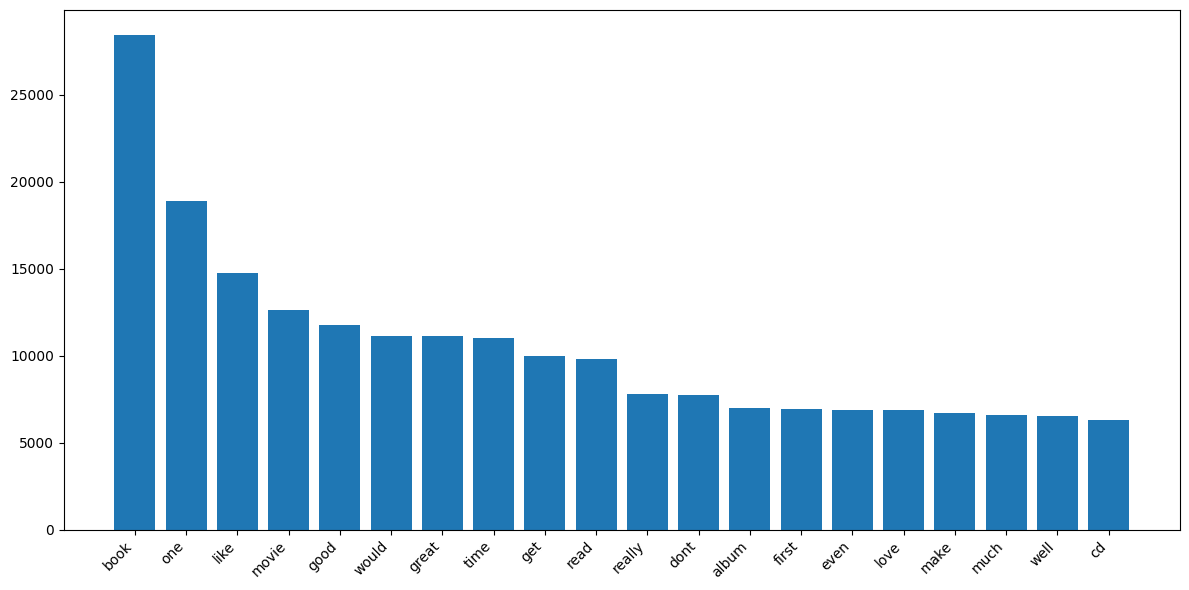

In [ ]:
# Bargraph
fig, ax = plt.subplots(figsize=(12, 6))
bar_data = fre[fre["frequency"] > 500].head(20)

ax.bar(bar_data["words"], bar_data["frequency"])
ax.set_xticks(range(len(bar_data)))
ax.set_xticklabels(bar_data["words"], rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Number of Negative and Positive reviews
df["sentimentLabel"].value_counts()

neg    25000
pos    25000
Name: sentimentLabel, dtype: int64

In [ ]:
## Splitting dataset into train/test
train_reviews=df.reviewText[:40000]
train_sentiments=df.sentimentLabel[:40000]
#test dataset
test_reviews=df.reviewText[40000:]
test_sentiments=df.sentimentLabel[40000:]

In [ ]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 2212151)
Tfidf_test: (10000, 2212151)


In [ ]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(df['sentimentLabel'])
print(sentiment_data.shape)

(50000, 1)


In [ ]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

[[0]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]
[[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [1]]


**Logistic Regression**

In [ ]:
# Model Training
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
# Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)


In [ ]:
## Predicting the model
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]


In [ ]:
# Logistic Regression Accuracy
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("Logistic Regression Accuracy :",lr_tfidf_score)

Logistic Regression Accuracy : 0.6524


In [ ]:
# Logistic Regression Scores
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.63      0.73      0.68      4925
    Negative       0.69      0.57      0.63      5075

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



**Linear SVM**

In [ ]:
# Training SVM
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
# Fitting the SVM for tfidf features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)


In [ ]:
# Predicting the model
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[0 0 0 ... 0 0 0]


In [ ]:
# Accuracy of SVM
svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict)
print("Accuracy of SVM :",svm_tfidf_score)

Accuracy of SVM : 0.4925


In [ ]:
# SVM Scores
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.49      1.00      0.66      4925
    Negative       0.00      0.00      0.00      5075

    accuracy                           0.49     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.24      0.49      0.33     10000



**NAIVE BAYES**

In [ ]:
# Model Training
nb=MultinomialNB()
# Fitting the Naive Bayes for tfidf features
nb_tfidf=nb.fit(tv_train_reviews,train_sentiments)
print(nb_tfidf)

MultinomialNB()


In [ ]:
# Predicting the model
nb_tfidf_predict=nb.predict(tv_test_reviews)
print(nb_tfidf_predict)

[0 0 0 ... 0 1 1]


In [ ]:
# Accuracy of Naive Bayes
nb_tfidf_score=accuracy_score(test_sentiments,nb_tfidf_predict)
print("Naive Bayes Accuracy :",nb_tfidf_score)

Naive Bayes Accuracy : 0.6536


In [ ]:
# Naive Bayes Score
nb_tfidf_report=classification_report(test_sentiments,nb_tfidf_predict,target_names=['Positive','Negative'])
print(nb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.63      0.70      0.67      4925
    Negative       0.68      0.61      0.64      5075

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



**CNN**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report

# Convert sparse matrices to dense arrays
tv_train_reviews = tv_train_reviews.toarray()
tv_test_reviews = tv_test_reviews.toarray()

# Define the vocabulary size, embedding dimension, and maximum sequence length
num_words = 10000
embedding_dim = 100
max_length = 100

# Pad or truncate the input sequences to a fixed length
tv_train_reviews = pad_sequences(tv_train_reviews, maxlen=max_length)
tv_test_reviews = pad_sequences(tv_test_reviews, maxlen=max_length)

# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_length))
cnn_model.add(Conv1D(128, 5, activation='relu',padding='same'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(tv_train_reviews, train_sentiments, epochs=5, batch_size=32)

# Predict using the CNN model
cnn_tfidf_predict = cnn_model.predict(tv_test_reviews)
cnn_tfidf_predict = (cnn_tfidf_predict > 0.5).astype(int)

# Calculate accuracy
cnn_tfidf_score = accuracy_score(test_sentiments, cnn_tfidf_predict)
print("CNN Accuracy:", cnn_tfidf_score)

# Calculate precision, recall, F1-score, and support
report = classification_report(test_sentiments, cnn_tfidf_predict, target_names=['Positive', 'Negative'])
print(report)


Epoch 1/5
1250/1250 [==============================] - 78s 61ms/step - loss: 0.6934 - accuracy: 0.5001
Epoch 2/5
1250/1250 [==============================] - 69s 55ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 3/5
1250/1250 [==============================] - 65s 52ms/step - loss: 0.6932 - accuracy: 0.5027
Epoch 4/5
1250/1250 [==============================] - 74s 59ms/step - loss: 0.6932 - accuracy: 0.4979
Epoch 5/5
313/313 [==============================] - 3s 9ms/step
CNN Accuracy: 0.4925
              precision    recall  f1-score   support

    Positive       0.49      1.00      0.66      4925
    Negative       0.00      0.00      0.00      5075

    accuracy                           0.49     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.24      0.49      0.33     10000



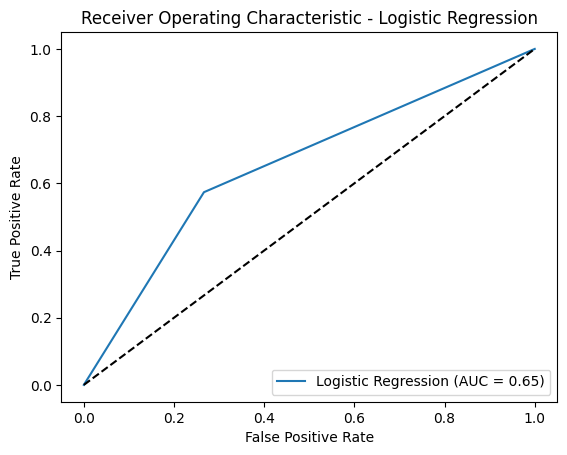

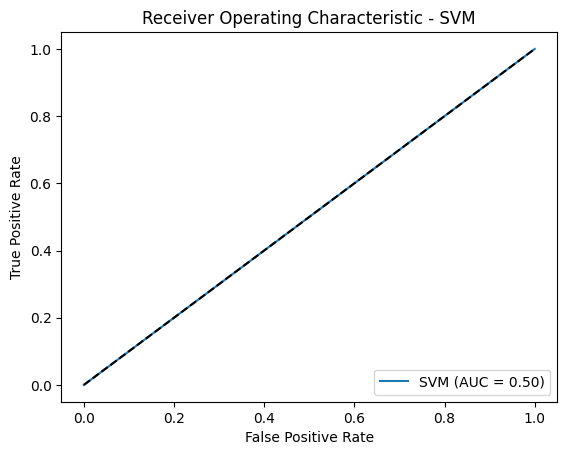

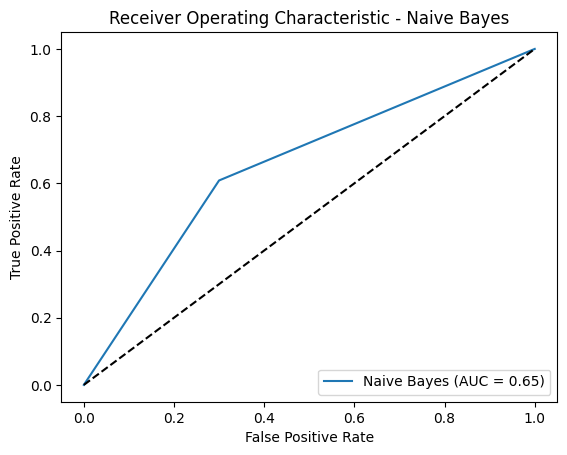

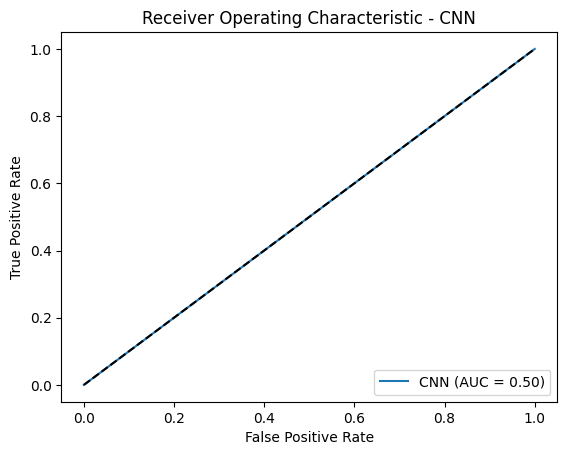

Logistic Regression ROC AUC: 0.653600060013503
SVM ROC AUC: 0.5
Naive Bayes ROC AUC: 0.6542872146232902
CNN ROC AUC: 0.5


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Logistic Regression
lr_fpr, lr_tpr, _ = roc_curve(test_sentiments, lr_tfidf_predict)
lr_auc = auc(lr_fpr, lr_tpr)

plt.figure()
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = {:.2f})'.format(lr_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc='lower right')
plt.show()

# SVM
svm_fpr, svm_tpr, _ = roc_curve(test_sentiments, svm_tfidf_predict)
svm_auc = auc(svm_fpr, svm_tpr)

plt.figure()
plt.plot(svm_fpr, svm_tpr, label='SVM (AUC = {:.2f})'.format(svm_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - SVM')
plt.legend(loc='lower right')
plt.show()

# Naive Bayes
nb_fpr, nb_tpr, _ = roc_curve(test_sentiments, nb_tfidf_predict)
nb_auc = auc(nb_fpr, nb_tpr)

plt.figure()
plt.plot(nb_fpr, nb_tpr, label='Naive Bayes (AUC = {:.2f})'.format(nb_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Naive Bayes')
plt.legend(loc='lower right')
plt.show()

# CNN
cnn_fpr, cnn_tpr, _ = roc_curve(test_sentiments, cnn_tfidf_predict)
cnn_auc = auc(cnn_fpr, cnn_tpr)

plt.figure()
plt.plot(cnn_fpr, cnn_tpr, label='CNN (AUC = {:.2f})'.format(cnn_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - CNN')
plt.legend(loc='lower right')
plt.show()

# Print ROC AUC scores
print("Logistic Regression ROC AUC:", lr_auc)
print("SVM ROC AUC:", svm_auc)
print("Naive Bayes ROC AUC:", nb_auc)
print("CNN ROC AUC:", cnn_auc)
